# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import numpy as np

training_file = "Data/train.p"
testing_file = "Data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
n_train = X_train.shape[0]
n_test = X_test.shape[0]
image_shape = X_train.shape[1:]
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [3]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

As a first step, let's take a look at an image to get an idea of what we're dealing with:

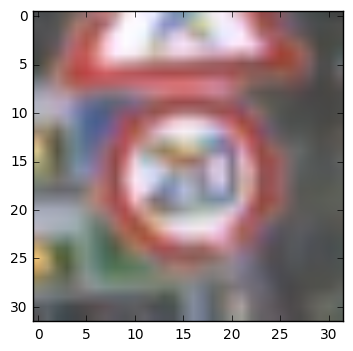

In [4]:
plt.imshow(X_train[0,...])

The image seems a little blurier than what I was expecting, but it is clear enough for me to easily see that it is a 20kph speed sign. 

### Normalization
Now that we have an idea of what an image from the dataset looks like, we need to normalize the images so that the optimizer in our model has an easier time converging. My implementation is as follows:
  * Convert the image to grayscale  
  * Equalize the histogram to account for variations in lighting conditions  
  * Divide by 255 and subtract 0.5 to clip the pixel range to [-0.5, 0.5]  

The below example shows the effect of this technique on a particularly difficult image.

Label: 6


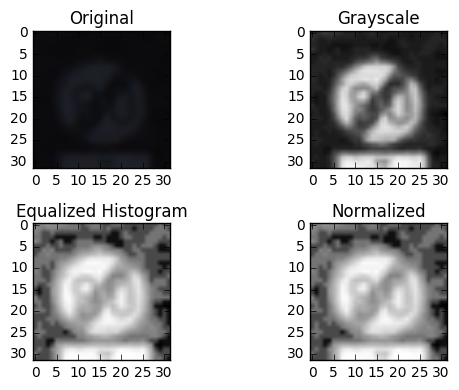

In [5]:
# Choose an image to visualize
im = 10000

# Copy the image
orig = np.copy(X_train[im,...])
print('Label: %d' % (y_train[im]))

# Convert to grayscale
gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)

# Equalize the histogram
eq_gray = cv2.equalizeHist(gray)

# Normalize the values
norm_gray = eq_gray/255. - 0.5

# Plot the results
fig = plt.figure()

grid = plt.subplot(2,2,1)
grid.set_title('Original')
grid.imshow(orig)

grid = plt.subplot(2,2,2)
grid.set_title('Grayscale')
grid.imshow(gray, cmap='gray')

grid = plt.subplot(2,2,3)
grid.set_title('Equalized Histogram')
grid.imshow(eq_gray, cmap='gray')

grid = plt.subplot(2,2,4)
grid.set_title('Normalized')
grid.imshow(norm_gray, cmap='gray')

plt.tight_layout()
plt.show()

As you can see, the difference between the original image and the final result is massive! It is now **much** easier to discern that this is a 80kph speed sign. The hope is that the model will percieve the same differences :)

### Class Distribution
Another worry when training a model is that the number of observations from each class will not be similar. This can be an issue at times if, for example, you have 1000 examples of class 'A' and only 5 examples of class 'B'. In this case, any model trained on this dataset would learn to always predict class 'A', and would be correct 99.5% of the time! 

So lets take a look at the distribution and see what we are dealing with:

39209 Observations


<Container object of 43 artists>

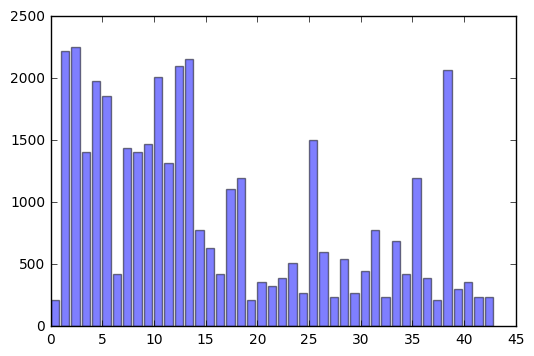

In [6]:
# Create a barchart of frequencies
item, count = np.unique(y_train, return_counts=True)
freq = np.array((item, count)).T

print('%d Observations' % (y_train.shape[0]))
plt.bar(item, count, alpha=0.5)

It is evident that about half of the classes in the dataset do **not** have nearly as many examples as we would want when training a model. It is my judgement that a model trained on this dataset would not have enough examples to accuratly distinguish between classes 0 and 1, for example. 

However, if this dataset represents the true proportions of class frequencies in the real world, we would not want to have an equal bias for class 0 and class 1. When the model is **uncertain**, we want it to predict class 1 (which is more frequent in the real world), but we also want it to be **capable** of predicting class 0. There is a fine line between inserting representational capability or non-exsistant bias into a model when augmenting a dataset.

When we address this issue later, I will outline my attempt to resolve it.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

### Implementation

Using the normalization method outlined above, we create the function `pre_process_gray` to generalize the method to multiple images. We also create functions to one-hot encode and de-one-hot encode the labels.

In [7]:
def pre_process_gray(images):
    # Convert images to grayscale
    tmp = []
    for i in range(images.shape[0]):
        gray = cv2.cvtColor(images[i,...], cv2.COLOR_BGR2GRAY)
        gray = cv2.equalizeHist(gray)
        norm_grey = gray/255. - 0.5
        tmp.append(norm_grey)
        
    tmp = np.array(tmp)
    return tmp[...,np.newaxis]

def one_hot(array):
    if array.ndim > 1: return array
    return np.array([[1 if j == array[i] else 0 for j in range(n_classes)] \
                     for i in range(len(array))])

def de_one_hot(array):
    if array.ndim == 1: return array
    return np.array([i.argmax() for i in array])

If everything works as expected, we expect the images to have shape (N, 32, 32, 3) to start, and (N, 32, 32, 1) to end. We will one-hot encode the labels at a later time, as they are easier to handle in a one-dimensional form.

In [8]:
print("Original Data Dims:\nData: %r | Labels: %r\n" % (X_train.shape, y_train.shape))

X_train = pre_process_gray(X_train)
print("Pre-Processed Data Dims:\nData: %r | Labels: %r\n" % (X_train.shape, y_train.shape))

Original Data Dims:
Data: (39209, 32, 32, 3) | Labels: (39209,)

Pre-Processed Data Dims:
Data: (39209, 32, 32, 1) | Labels: (39209,)



### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**  
The first step I took to pre-process the images was to convert them to grayscale. I chose to convert them to grayscale by a process of elimination. E.G. the grayscale images performed better :) I believe the grayscale images performed better due to the 3x1x1 convolution at the beginning of my model. This convolution has the effect of allowing the model to choose its own color mapping for the images, and the grayscale inputs reduced the complexity and variation of this process.

Once converted, I noticed that there was varying brightness between images, so I researched methods to normalize these descrepancies. The method I chose to use was equalizing the histogram of the image, as it was easy to implement with cv2 and it did not rely on global training set data, reducing the chance of data snooping occuring during testing.

Lastly, I normalized the pixel range to between [-0.5, 0.5] to create a well-conditioned problem for the optimizer to converge to a solution. 

At a later time, I will one-hot encode the labels. I am leaving them as-is for now to make life simpler when expanding the dataset.

### Data Augmentation and Test/Validation Setup

Now that our images are transformed and normalized, we need to expand the dataset to give the model a better chance of converging to a solution. 

When viewing an object from a fixed viewpoint, we can simulate the view of the **same** object from a **different** viewpoint by using affine transformations. Affine transformations are any linear transformation of a matrix which maintains the parrallelism of the lines in the image. Examples of such transformations include rotation, translation, and shear.

Using the below function, we will create randomized transformations of our training images to simulate viewing the traffic signs from different angles, with the hope that this will make our model more robust in classification of new images.

In [9]:
def transform_image(image, angle, shear, translation):
    ang_rot = np.random.uniform(angle) - angle/2
    rows, cols, color_channels = image.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)

    trans_x = translation*np.random.uniform() - translation/2
    trans_y = translation*np.random.uniform() - translation/2
    translation_matrix = np.array([[1, 0, trans_x],[0, 1, trans_y]]).astype('float32')
    
    pts1 = np.array([[5,5],[20,5],[5,20]]).astype('float32')
    
    pt1 = 5 + shear*np.random.uniform()- shear/2
    pt2 = 20 + shear*np.random.uniform()- shear/2
    
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_matrix = cv2.getAffineTransform(pts1, pts2)
        
    image = cv2.warpAffine(image, rotation_matrix, (cols,rows))
    image = cv2.warpAffine(image, translation_matrix,(cols,rows))
    image = cv2.warpAffine(image, shear_matrix, (cols,rows))
    
    return image

Let's test the function on a random image to see it's effect.

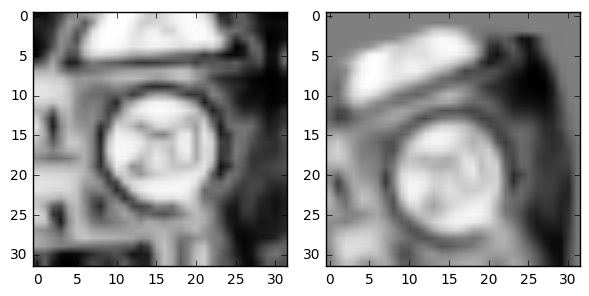

In [10]:
im = 0

transformed = transform_image(X_train[im,...], 20, 10, 5)
stacked = np.dstack((X_train[im,...], transformed))

grid = plt.subplot(1,2,1)
plt.imshow(stacked[...,0], cmap='gray')

grid = plt.subplot(1,2,2)
plt.imshow(transformed, cmap='gray')

plt.tight_layout()

Perfect! Now that we have a method to expand the dataset in a pricipled manner, we need to decide what classes to expand and by how much. Recall the class distribution chart from earlier. Many classes had fewer than 250 observations, making it unlikely that our model will predict these classes correctly. However, we do not want to mess with the distribution of the classes **too** much, as we must assume that the inherent bias in observation size corresponds to the probability of observing that sign on a road.
  
So, it's evident that we would like to expand the small classes by a lot to make the model recognize them, and the large classes by a little so as to simulate the different viewing angles and maintain class hierarchy. The first thing we need to do is segregate each class into its own dataset, and then expand that set by a varying amount based upon its size. Lastly, we need to recombine these class sets into our newly augmented training dataset.

In [11]:
segregated_data = []
class_obs = []

for class_ in range(n_classes):
    segregated_class = X_train[y_train == class_,...]
    segregated_data.append(segregated_class)
    class_obs.append(segregated_class.shape[0])

The scaling factors I chose were as follows:
* If <250 observations, increase size by 8x
* If <500 observations, increase size by 4x
* Else, increase size by 2x

In [12]:
def expand_class(images, n_obs):
    transformed_images = []
    
    if n_obs < 500: factor = 8
    elif n_obs < 1000: factor = 4
    else: factor = 2
    
    for image in images:
        for _ in range(factor-1):
            transformed_images.append(transform_image(image, 20, 10, 5))
    
    transformed_images = np.array(transformed_images)
    transformed_images = transformed_images[...,np.newaxis]
    expanded_class = np.concatenate((images, transformed_images), axis=0)
    return (expanded_class, expanded_class.shape[0])

In [13]:
expanded_data = None
expanded_labels = None

for class_, images in enumerate(segregated_data):
    if expanded_data is None:
        expanded_data, obs = expand_class(images, class_obs[class_])
        expanded_labels = np.full(obs, class_, dtype='int64')
    else:
        tmp, obs = expand_class(images, class_obs[class_])
        expanded_data = np.concatenate((expanded_data, tmp), axis=0)
        expanded_labels = np.concatenate((expanded_labels, np.full(obs, class_, dtype='int64')), axis=0)

del segregated_data, class_obs
print("Expanded Data Dims:\nData: %r | Labels: %r\n" % (expanded_data.shape, expanded_labels.shape))

Expanded Data Dims:
Data: (123296, 32, 32, 1) | Labels: (123296,)



All in all, we expanded our training dataset from 39,209 observations, to 123,296 observations. But did the classes scale as we expected them to, with smaller classes expanding more than larger classes? Lets take another look at the bar-chart and see how we fared.

123296 Observations


<Container object of 43 artists>

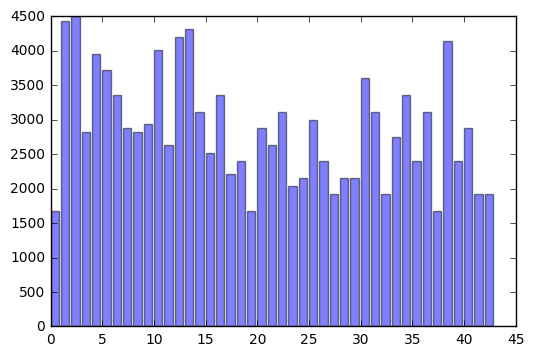

In [14]:
# Create a barchart of frequencies
item, count = np.unique(expanded_labels, return_counts=True)
freq = np.array((item, count)).T

print('%d Observations' % (expanded_labels.shape[0]))
plt.bar(item, count, alpha=0.5)

Looking good! Our class distribution is **much** more regular now! Now all that's left to do is split this data into training and validation sets. Below are some methods I created to shuffle the dataset, as currently it is ordered by class, and split a dataset into two sets with N% and (1-N)% in each, respectively.

In [15]:
def shuffle(X, y=None):
    """
    Given data (X) and labels (y), randomly shuffles their order.
    """
    X_shuffled, y_shuffled = [],[]
    n_obs = X.shape[0]

    for i in np.random.permutation(n_obs):
        X_shuffled.append(X[i,...])

        if y is None: y_shuffled.append(0)
        else: y_shuffled.append(y[i,...])
    return (np.array(X_shuffled), np.array(y_shuffled))

def train_val_split(data, labels, train_percent):
    n_obs = data.shape[0]
    assert n_obs == labels.shape[0], "Different number of images and labels"
    
    data, labels = shuffle(data, labels)
    
    cutoff = np.round(train_percent * n_obs).astype('int64')
    
    train = (data[:cutoff,...], labels[:cutoff])
    val = (data[cutoff:,...], labels[cutoff:])
    
    assert train[0].shape[0] + val[0].shape[0] == n_obs, "I fucked up"
    return (train, val)

In [16]:
train_percent = 0.8

expanded_labels = one_hot(expanded_labels)
train, val = train_val_split(expanded_data, expanded_labels, train_percent)

X_test, y_test = pre_process_gray(X_test), one_hot(y_test)
test = (X_test, y_test)

print("Train Size: %d | Val Size: %d | Test Size: %d"
     % (train[0].shape[0], val[0].shape[0], test[0].shape[0]))

Train Size: 98637 | Val Size: 24659 | Test Size: 12630


And now we **finally** get to use the `one_hot` method we created earlier! After all is said and done, we have 72.5% of our data in the train set, 18.1% in our validation set, and 9.3% in our test set. We also made sure to leave the data in the test set **untouched** (excepting preprocessing), so we can compare our results to others work.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**  
Summarizing from above, I used affine transformations to generalize training images to different viewpoints, expanded classes with fewer observations more than classes with higher observations, shuffled the dataset, and split the expanded training set 80/20 into train/validation sets. I left the testing set untouched except for the preprocessing, which did not use any information external to the set, avoiding data snooping.

# Time to Train the Model

Now that all of the preliminary steps have been completed, we can get to model construction and training. To make my life easier when iterating through model structures, I created a class `ConvNet` in the **models.py** file contained in this directory. The class automates the setup, training, and scoreing of a convolutional neural network in TensorFlow. I like to think of it as my own tiny Keras :) 

You can run `?ConvNet` after importing it to get a more thourough explanation of its functionality. For some reason, jupyter notebooks wont print docstrings inline...

In [27]:
from models import ConvNet
import tensorflow as tf

SignClassifier = ConvNet(batch_size=32, color_channels=1, image_shape=(32,32), 
                         n_classes=43, learning_rate=1e-3)

SignClassifier.conv2d('L0', kernel_size=1, depth=3, ACTIVATION=tf.nn.elu)

SignClassifier.conv2d('conv1_1', kernel_size=3, depth=32, input_padding=1, ACTIVATION=tf.nn.elu)
SignClassifier.conv2d('conv1_2', kernel_size=3, depth=32, input_padding=1, ACTIVATION=tf.nn.elu)
SignClassifier.pool2d('MAX')

SignClassifier.conv2d('conv2_1', kernel_size=3, depth=64, input_padding=2, ACTIVATION=tf.nn.elu)
SignClassifier.conv2d('conv2_2', kernel_size=3, depth=64, input_padding=2, ACTIVATION=tf.nn.elu)
SignClassifier.pool2d('MAX')

SignClassifier.conv2d('conv3_1', kernel_size=3, depth=128, input_padding=1, ACTIVATION=tf.nn.elu)
SignClassifier.conv2d('conv3_2', kernel_size=3, depth=128, input_padding=1, ACTIVATION=tf.nn.elu)
SignClassifier.pool2d('MAX')

SignClassifier.fully_connected('FC1', 1024, ACTIVATION=tf.nn.elu)
SignClassifier.dropout()

SignClassifier.fully_connected('FC2', 512, ACTIVATION=tf.nn.elu)
SignClassifier.dropout()

SignClassifier.fully_connected('FC3', 256, ACTIVATION=tf.nn.elu)
SignClassifier.dropout()

SignClassifier.fully_connected('FC4', 256, ACTIVATION=tf.nn.elu)

SignClassifier.fully_connected('OUT', 43, ACTIVATION=None)



### Question 3

*What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)*

**Answer:**  
I used a Convolutional Neural Network with architecture:
  
* Convolutional Layer: 3x3x32
* Convolutional Layer: 3x3x32
* Max Pooling Layer: 2x2 Kernel with step size of 2  
  
  
* Convolutional Layer: 3x3x64
* Convolutional Layer: 3x3x64
* Max Pooling Layer: 2x2 Kernel with step size of 2  
  
  
* Convolutional Layer: 3x3x128
* Convolutional Layer: 3x3x128
* Max Pooling Layer: 2x2 Kernel with step size of 2  
  
  
* Fully Connected Layer: 1024 Neurons
* Dropout Layer: Keep Prob of 0.5
  
  
* Fully Connected Layer: 512 Neurons
* Dropout Layer: Keep Prob of 0.5
  
  
* Fully Connected Layer: 256 Neurons
* Dropout Layer: Keep Prob of 0.5


* Fully Connected Layer: 256 Neurons


* Output Layer: 43 Neurons  

I used Exponential Linear Unit (ELU) activation functions.

In [28]:
SignClassifier.train(train, val, max_epochs=100, l2_beta=0.001, patience=10)

Starting training process:
 Epoch: 001 | 100.0% - Loss: 11.924211402 | Validation Acc: 56.4535% - Best!
 Epoch: 002 | 100.0% - Loss: 2.885491620 | Validation Acc: 74.5595% - Best!
 Epoch: 003 | 100.0% - Loss: 2.455634980 | Validation Acc: 82.0510% - Best!
 Epoch: 004 | 100.0% - Loss: 2.309785156 | Validation Acc: 89.8845% - Best!
 Epoch: 005 | 100.0% - Loss: 2.136656277 | Validation Acc: 92.4773% - Best!
 Epoch: 006 | 100.0% - Loss: 2.002551967Epoch: 006 | 032.2% - Loss: 2.042772129 | Validation Acc: 95.2213% - Best!
 Epoch: 007 | 100.0% - Loss: 1.877211642 | Validation Acc: 95.7847% - Best!
 Epoch: 008 | 100.0% - Loss: 1.809267825 | Validation Acc: 96.1211% - Best!
 Epoch: 009 | 100.0% - Loss: 1.719492951 | Validation Acc: 95.3470%
 Epoch: 010 | 100.0% - Loss: 1.737941852 | Validation Acc: 96.1860% - Best!
 Epoch: 011 | 100.0% - Loss: 1.692681219 | Validation Acc: 96.3116% - Best!
 Epoch: 012 | 100.0% - Loss: 1.644562874 | Validation Acc: 96.5832% - Best!
 Epoch: 013 | 100.0% - Loss: 

Normalized confusion matrix
Accuracy: 0.96809


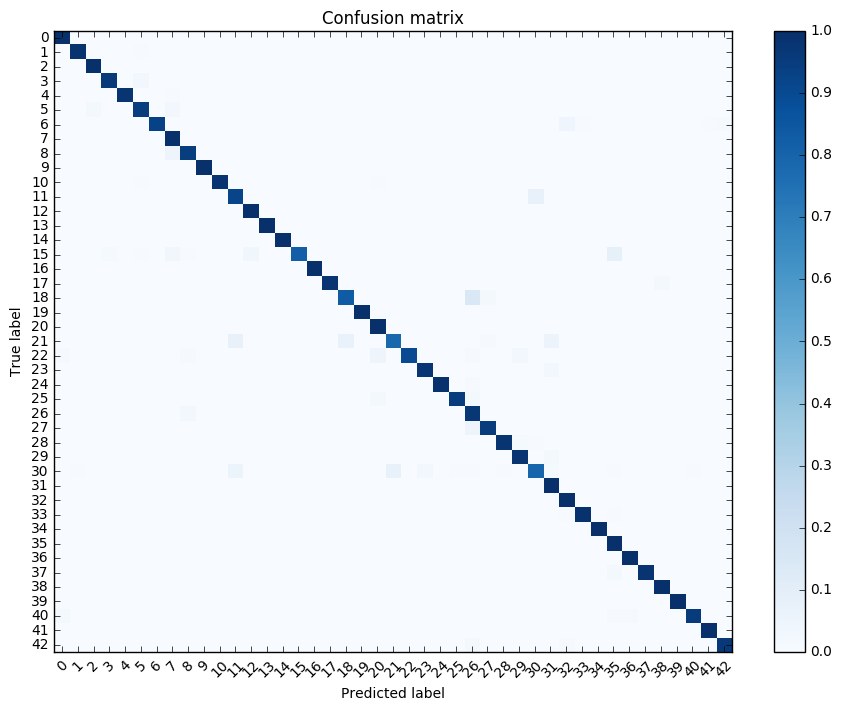

In [29]:
print("Accuracy: %1.5f" % (SignClassifier.score(test, plot=True, normalize=True)))

Not a bad result!! We achieved a 96.81% accuracy on our test set!

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**  

**Optimizer:**  Adam Optimizer  
**Learning Rate:**  0.001  
**Batch Size:**  64  
**Beta for L2-Regularization:**  0.001  
**Max Epochs:** 100  
**Patience:** 10  
  
I chose to use the Adam Optimizer because I read that it converges to a solution much faster and more reliably than stochastic gradient descent. The learning rate comes from the default settings for the optimizer. I chose a batch size of 64 because this was the biggest size I could reliably fit in my GPU memory (3.5GB). A larger batch size will, in most situations, lead to a faster convergence due to the reduction in noise. 

I chose a L2-Regularization factor of 0.001 to help prevent overfitting without limiting the representational capacity of the model. I chose a max epochs of 100 to ensure that the model would begin to overfit, which ensures that a maximum validation accuracy would be reached. The weights for the model were only saved if the new validation accuracy was higher than the previous best. If the model did not improve the validation accuracy for 10 epochs, training was stopped and the weights with the best validation accuracy were returned. 

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**  
This project was very interesting and informative, and I learned a lot about the intricacies and implementation of convolutional neural networks in TensorFlow. I took quite a bit of inspiration from Vivek Yadav's [work](https://chatbotslife.com/german-sign-classification-using-deep-learning-neural-networks-98-8-solution-d05656bf51ad#.l55w6xh39) on this project. Using his techniques as a starting point, I was able to get very good results.
  
My steps were mainly trial and error, alongside iterating on my ConvNet class to improve it's functionality and provide relevant information on the model performance. To arrive at the architecture I have now, I set up Vivek's architecture and trained it to see the results. If the results were not good enough, I added another layer to the model. I repeated this process untill the model began to overfit to the training data. 
  
Once this occured, I added L2-Regularization to the loss to help dampen the overfitting, and ran the model a couple more times to tune the Beta value. L2-Regularization helps to prevent overfitting by constraining the optimization function to a hyper-sphere around the origin. If the local/global optimum lies outside this sphere, the optimizer cannot reach it. Another way to think about it is that L2-Regularizaion prevents the optimizer from using all of the degrees of freedom in the hypothesis set of functions. A well tuned regularization constant will allow the model to have *just enough* degrees of freedom to fit the objective function as well as possible without going crazy to fit each data point perfectly.
  
In addition to L2-Loss, I added several dropout layers to the fully connected layers in the model. Dropout randomly sets weights in a layer to zero during training. This has the effect of forcing the model to not rely on any one neuron to make accurate predictions, enforcing sparcity on the weights of the layer. Dropout is very effective at preventing overfitting, as it essentailly creates an ensemble of smaller nets all voting on the correct prediction. 
  
I chose to use the softmax activation function for my outputs, as this function would allow the model to express it's **certainty** in it's prediction. This allowed me to inspect what the model was thinking. E.G. if its highest predicted class had a value of 0.99, the model was very certian about its prediction. However, if the models highest predicted class had a value of 0.3, it was most likely confused by the image. Additionally, if the model was very certain about a prediction that was incorrect, it had probably overfitted to the training data.
  
I chose to use the cross entropy loss function, as this allows the model to train against a multi-class dataset. The other option would have been to discretize the output and train with mean-squared error. However, this approach would not allow the model to express its certainty about it's predictions, so I decided to stay with cross-entropy.

My activation function for the convolutional layers were Exponential Linear Units (ELU). This function is similar to the ReLU activation, except that instead of a linear positive half and a zero negative half, it uses a linear negative half and an exponential positive half. This activation function helps prevent neurons from 'dissappearing', or becoming so negative that they will *never* become activated again.
  
I added max-pooling layers to help the model become scale and translation invariant. Max-pooling helps to achieve this by only propogating the highest activation in a region, effectively shrinking the seach space for features and increasing the receptive field for higher level features.
  
In conclusion, I am very pleased with the results I achieved.I will most likely come back to this project in the future to see if I can improve my accuracy.

---

## Step 3: Test the Model on New Images

Now that we have a fully trained model, let's see how it performs on images taken from outside the dataset. I went online and downloaded 6 images of various traffic signs, and we will go through the steps of transforming their shape and predicting their class below.

### Loading and Transforming the Images

I placed the testing images in their own directory `test_images`. Since these images were downloaded from google, they are not as nicely formatted as our original dataset. The first thing we need to do is ensure that the images are 32x32x3 so we can pre-process and feed them into our model. Once this is done, we can apply the same pre-processing as our original dataset, using our `pre_process_gray` function.

In [30]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
import matplotlib.pyplot as plt
import cv2

test_images = []
path = './test_images/'
for image in os.listdir(path):
    img = cv2.imread(path + image)
    img = cv2.resize(img, (32,32))
    test_images.append(img)

test_images = np.array(test_images)
test_images = pre_process_gray(test_images)

Let's take a look at what the images look like now!

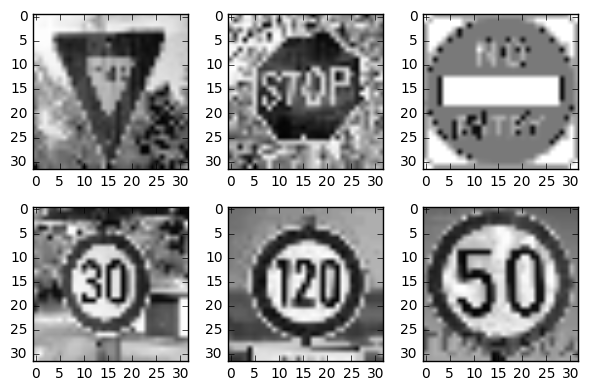

In [31]:
fig = plt.figure()

for i, image in enumerate(test_images):
    grid = plt.subplot(2,3,i+1)
    grid.imshow(image[...,0], cmap='gray')

plt.tight_layout()
plt.show()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**  
For the Yeild and Stop signs, the noise in the backgroud from the trees/foliage could confuse the model. For the No Entry sign, the noise over the words on the sign may prevent it from converging to the correct label. For the Speed signs, I do not see any reason why the model would not predict these correctly.

Now that we have the images loaded and pre-processed, all that's left to do is create an array with their labels and see how the model performs!

In [32]:
import pandas as pd

labels = np.array([13, 14, 17, 1, 8, 2])
pred = de_one_hot(SignClassifier.predict(test_images))

df = pd.DataFrame(data=np.array((labels, pred)).T, columns=['Labels', 'Predictions'])
acc = SignClassifier.score((test_images, one_hot(labels)))

print('Accuracy: %1.5f\n\n' % (acc), df)

Accuracy: 1.00000

    Labels  Predictions
0      13           13
1      14           14
2      17           17
3       1            1
4       8            8
5       2            2


### Question 7

*Is your model able to perform equally well on captured pictures when compared to testing on the dataset?*

**Answer:**  
The short answer is yes! :) The model was able to predict all of the images correctly! HOWEVER, this is a very small sample size and we can't be sure that it will generalize well to all external images.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions.*

In [33]:
def vizualize_softmax_probabilities(model, image, num_probs, correct_prediction=None):
    import pandas as pd
    import matplotlib.pylab as plt
    
    if image.ndim == 3:
        image = image[np.newaxis,...]
    if image.shape[3] > 1:
        image = pre_process_gray(image)
    
    pred = model.predict(image)[0]
    top_k = np.argsort(pred)[:-(num_probs+1):-1]
    
    pred = pd.DataFrame(data=np.array((top_k, pred[top_k])).T, columns=['ClassId', 'Probability'])
    names = pd.read_csv('./signnames.csv', header=0)
    pred = pd.merge(pred, names, how='inner', on='ClassId')
    
    fig = plt.figure(figsize=(11,7))
    grid = plt.subplot(1,2,1)
    
    if correct_prediction is not None:
        name = names.at[correct_prediction, 'SignName']
        grid.set_title("Correct Prediction: " + name)
    
    plt.imshow(image[0,:,:,0], cmap='gray')
    
    grid = plt.subplot(1,2,2)
    plt.barh(np.arange(num_probs)[::-1], np.array(pred['Probability']), align='center')
    plt.xlim([0,1.0])
    plt.yticks(np.arange(num_probs)[::-1], np.array(pred['SignName']))
    
    plt.tight_layout()

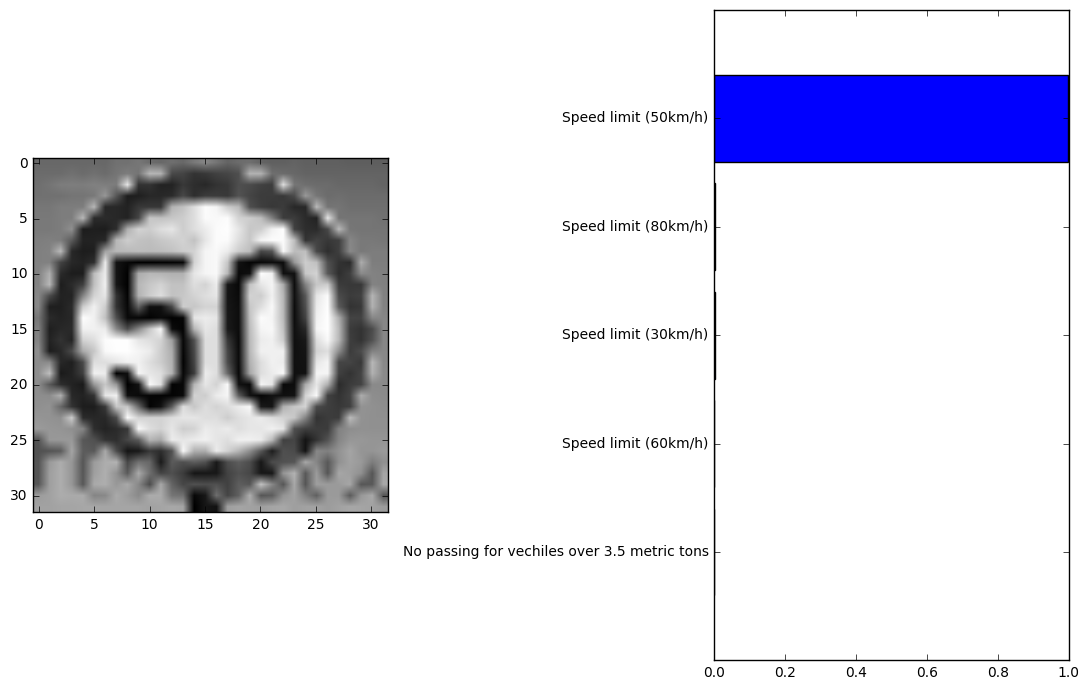

In [34]:
vizualize_softmax_probabilities(SignClassifier, test_images[5], num_probs=5)

As we can see, the model very confident that this is a 50kph sign :)

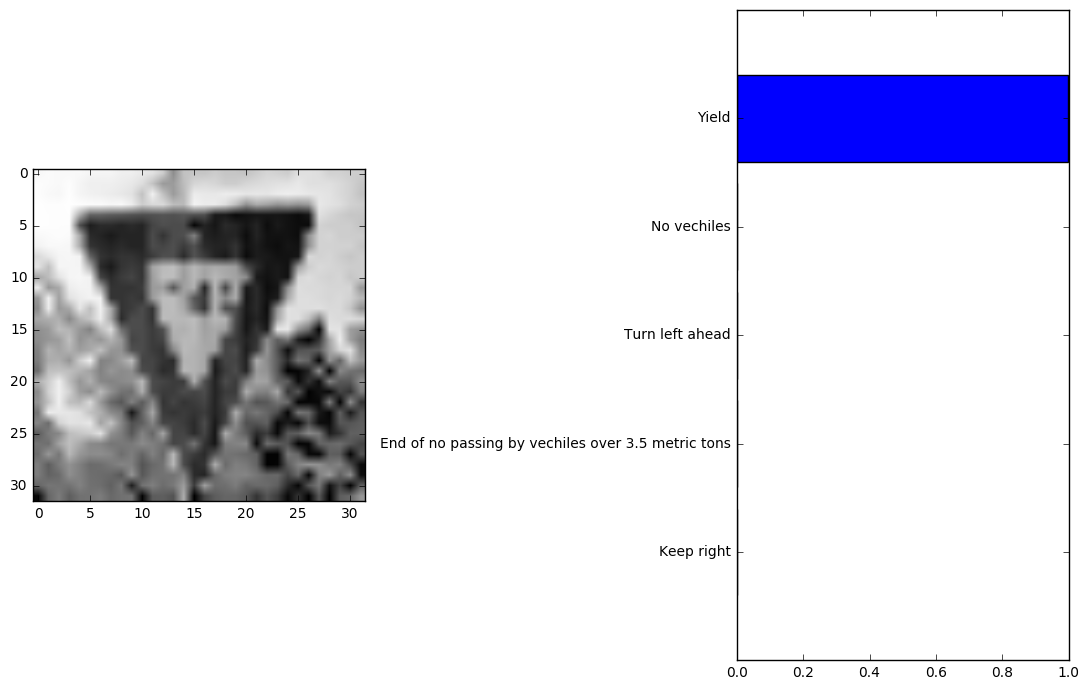

In [35]:
vizualize_softmax_probabilities(SignClassifier, test_images[0], num_probs=5)

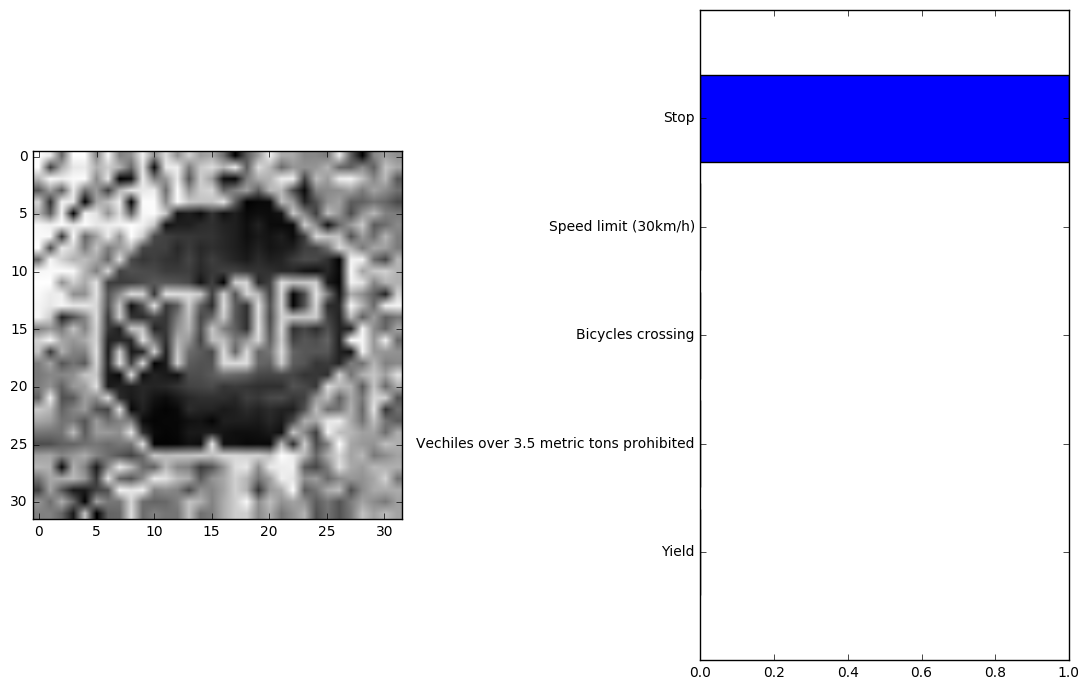

In [36]:
vizualize_softmax_probabilities(SignClassifier, test_images[1], num_probs=5)

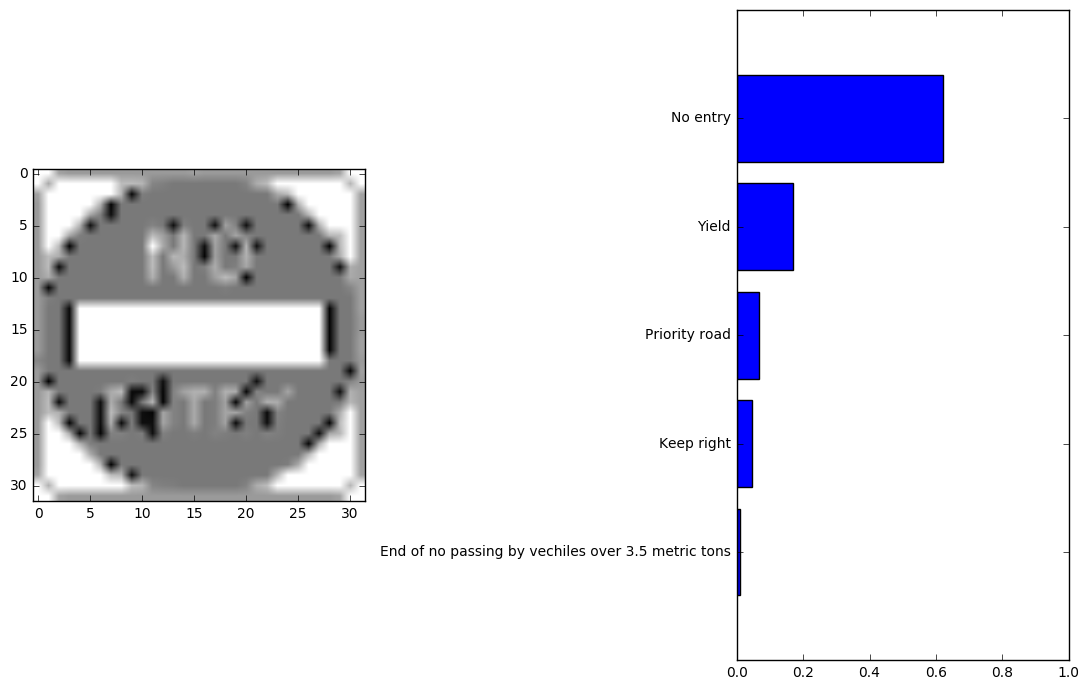

In [37]:
vizualize_softmax_probabilities(SignClassifier, test_images[2], num_probs=5)

The model is usually very confident in it's predictions, and so far it's always correct! However, it is not very certian of the no entry sign, most likly due to the noise over the words on the sign.

## Incorrectly Classified Test Images

As a final step, let's take a look at some incorrectly classified images from our non-googled testing set to analyze the main source of our error.

In [38]:
pred = de_one_hot(SignClassifier.predict(X_test))
actual = de_one_hot(y_test)

In [39]:
correct = [pred[i] == actual[i] for i in range(len(pred))]
incorrect = []

for i, accurate in enumerate(correct):
    if accurate == False:
        incorrect.append(i)

print("Number of Incorrect Examples: %d out of %d" % (len(incorrect), len(y_test)))

Number of Incorrect Examples: 403 out of 12630


Now that we have a list of the errors our model made on the test set, lets take a look at the most common error our model made in prediction:

In [40]:
for c in range(n_classes):
    inc = 0
    for i, class_ in enumerate(actual[incorrect]):
        if class_ == c:
            inc += 1
    print("Accuracy for Class %02d: %1.4f" % (c, 1 - inc/sum([1 if i == c else 0 for i in actual])))

Accuracy for Class 00: 1.0000
Accuracy for Class 01: 0.9847
Accuracy for Class 02: 0.9947
Accuracy for Class 03: 0.9644
Accuracy for Class 04: 0.9818
Accuracy for Class 05: 0.9460
Accuracy for Class 06: 0.9267
Accuracy for Class 07: 0.9978
Accuracy for Class 08: 0.9467
Accuracy for Class 09: 0.9979
Accuracy for Class 10: 0.9773
Accuracy for Class 11: 0.9190
Accuracy for Class 12: 0.9942
Accuracy for Class 13: 0.9972
Accuracy for Class 14: 0.9926
Accuracy for Class 15: 0.8190
Accuracy for Class 16: 1.0000
Accuracy for Class 17: 0.9778
Accuracy for Class 18: 0.8282
Accuracy for Class 19: 1.0000
Accuracy for Class 20: 1.0000
Accuracy for Class 21: 0.7889
Accuracy for Class 22: 0.9000
Accuracy for Class 23: 0.9733
Accuracy for Class 24: 0.9889
Accuracy for Class 25: 0.9521
Accuracy for Class 26: 0.9722
Accuracy for Class 27: 0.9500
Accuracy for Class 28: 0.9800
Accuracy for Class 29: 0.9778
Accuracy for Class 30: 0.7933
Accuracy for Class 31: 0.9963
Accuracy for Class 32: 1.0000
Accuracy f

Looking through the accuracies, it appears that class 30 actualy has a **much** lower accuracy than class 5, so we will look at some examples and see what the model is thinking.

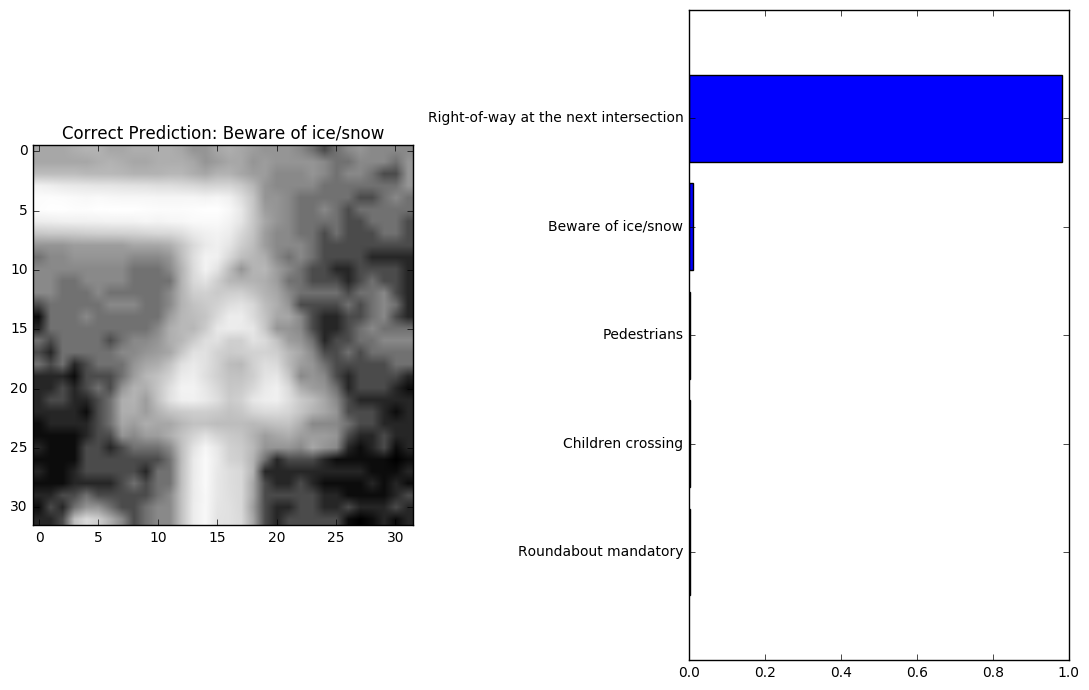

In [72]:
vizualize_softmax_probabilities(SignClassifier, X_test[72], num_probs=5, correct_prediction=actual[72])

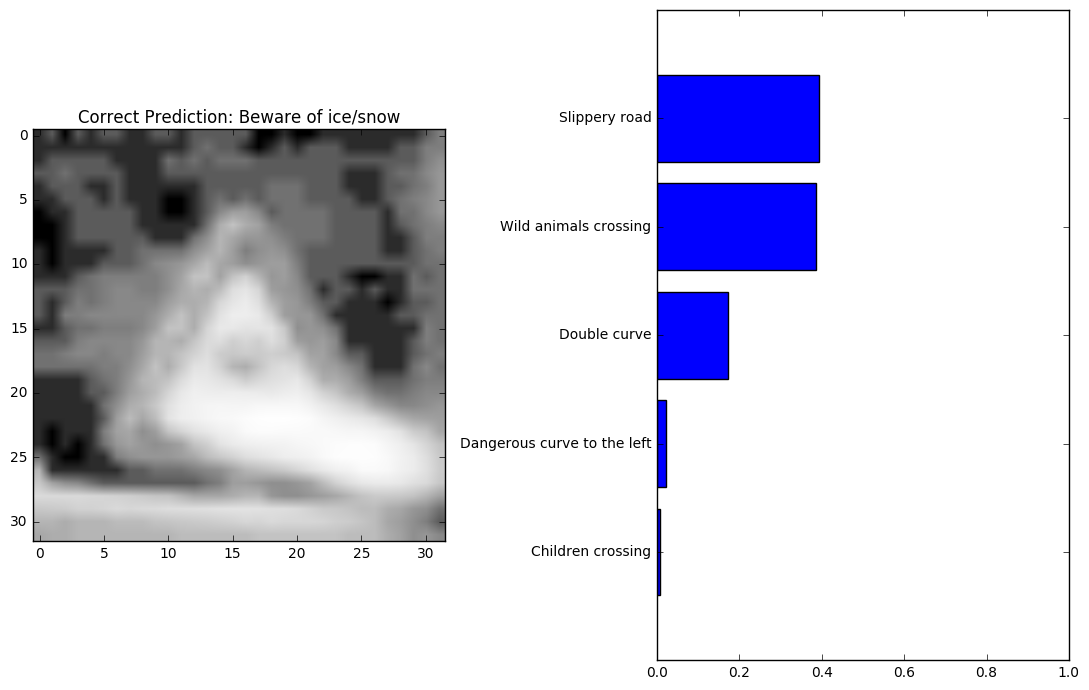

In [73]:
vizualize_softmax_probabilities(SignClassifier, X_test[114], num_probs=5, correct_prediction=actual[114])

As we can see, the images in this class are very distorted due to the normalization process. In a future run of this model, I will adjust the normalization procedure to make all classes recognizable. However even with the distortions, the model predicts the correct label as second most likely for the first image, and a similar label (slippery road) for the second image.

As a final omage, let's see how our models did when predicting the original hard sample image we used when testing normalization **way** earlier.

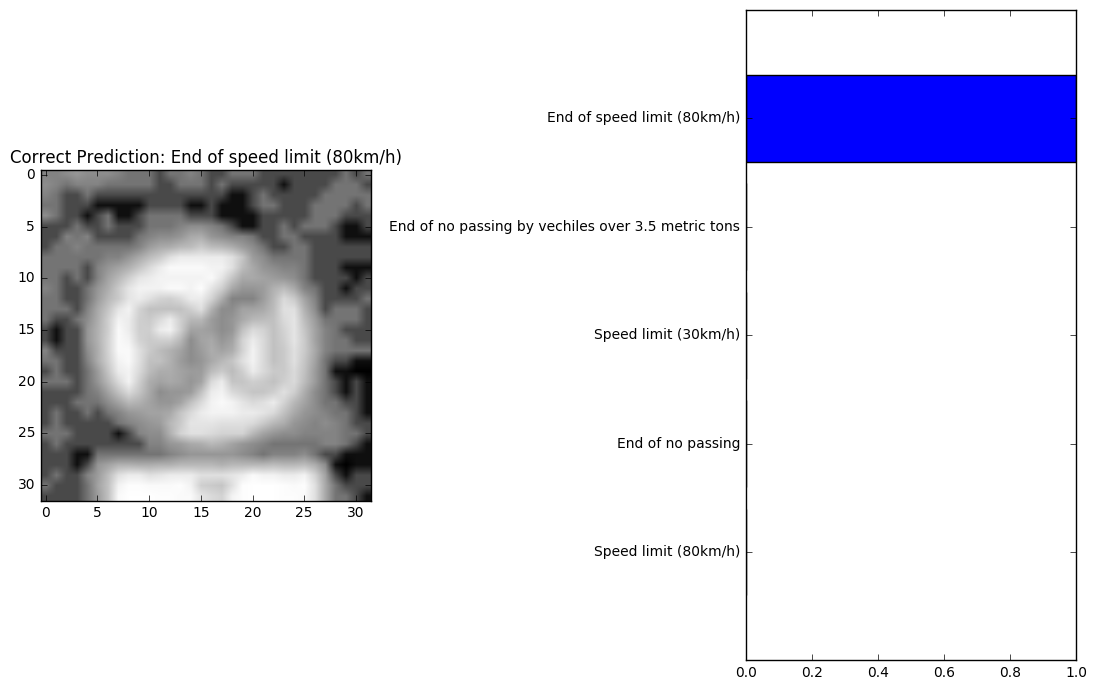

In [74]:
vizualize_softmax_probabilities(SignClassifier, X_train[10000], num_probs=5, 
                                correct_prediction=de_one_hot(y_train)[10000])

Sweet!! 100% confident **and** it's correct :) I hope you enjoyed grading my project! Thank you for taking the time to read through it, I am very happy with the results and I hope that my explanations made sense.